# Projeto Final - Implementação do Crow Search Algorithm
Grupo: Frederico Janovitz / Klarissa Morais / Leônidas Netto

## Introdução

- Para este projeto, serão utilizadas quatro funções de benchmark para analisar o funcionamento do Crow Search Algortihm e algumas de suas variantes. Além disso, serão utilizados um algoritmo genético e uma estratégia evolutiva para fins de comparação. As funções que serão utilizadas serão as funções de Ackley, Rastrigin, Schwefel e Rosenbrock.

- Bibliotecas importadas:

In [ ]:
import random
import numpy as np
from math import pi
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from rich.console import Console
from rich.table import Table
import seaborn as sns

- Funções de otimização que serão utilizadas:

In [ ]:
# Funções de fitness
def ackley(vector):
    n = len(vector)
    sv = sum([x*x for x in vector])
    a = -0.2 * np.sqrt(1/n * sv)
    b = 1/n * sum([np.cos(2 * np.pi * x) for x in vector])
    value = -20 * np.exp(a) - np.exp(b) + 20 + np.e
    return value

def rastrigin(vector):
    A = 10
    An = A * len(vector)
    v = sum([np.power(x, 2) - A * np.cos(2 * np.pi * x) for x in vector])
    value = An + v
    return value

def schwefel(vector):
    value = 418.9829 * len(vector) - np.sum(vector * np.sin(np.sqrt(np.abs(vector))))
    return value

def rosenbrock(vector):
    sum_val = 0
    for i in range(len(vector) - 1):
        sum_val += 100 * (vector[i + 1] - vector[i]**2)**2 + (1 - vector[i])**2
    return sum_val

# Limites de cada função
bounds = {"Ackley": [-32.768, 32.768], "Rastrigin":  [-5.12, 5.12], "Schwefel": [-500, 500], "Rosenbrock": [-2.048, 2.048]}

- Parâmetros comuns a todos os algoritmos:

In [ ]:
dimensions = 30
max_generations = 500
executions = 30

- Gráficos das funções de otimização selecionadas:

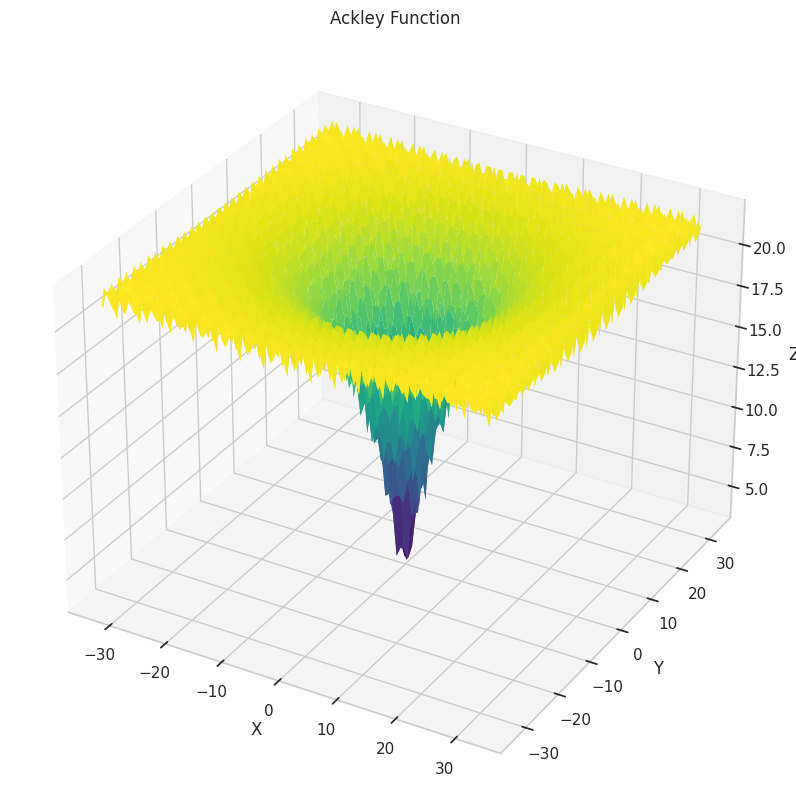

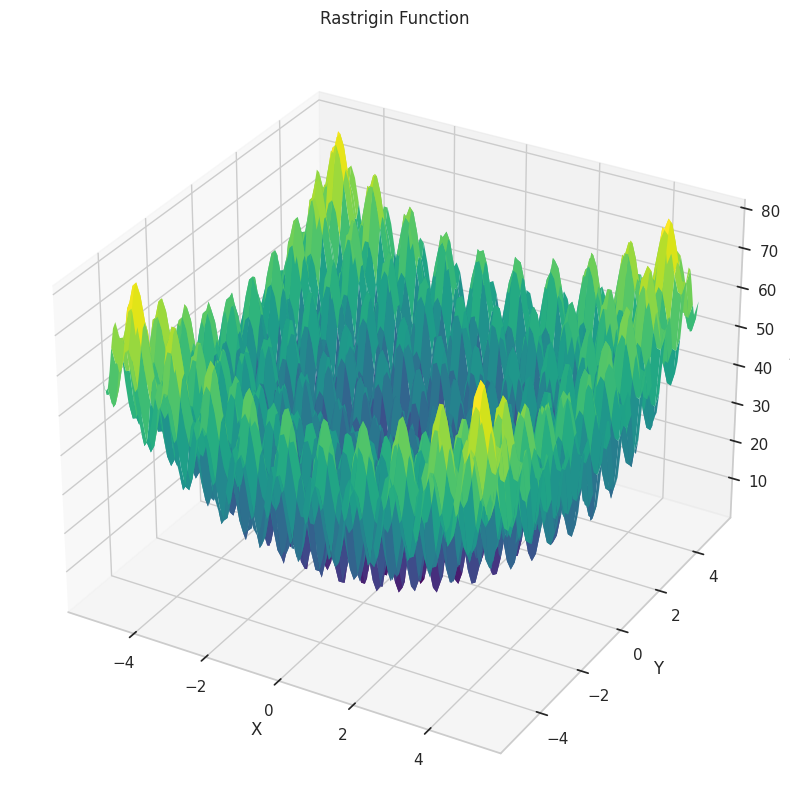

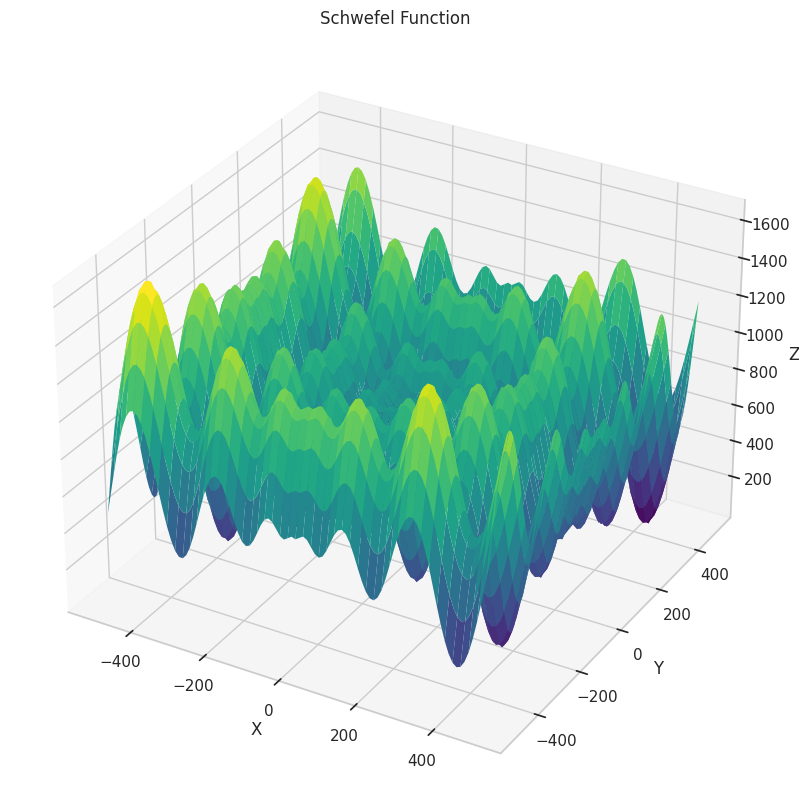

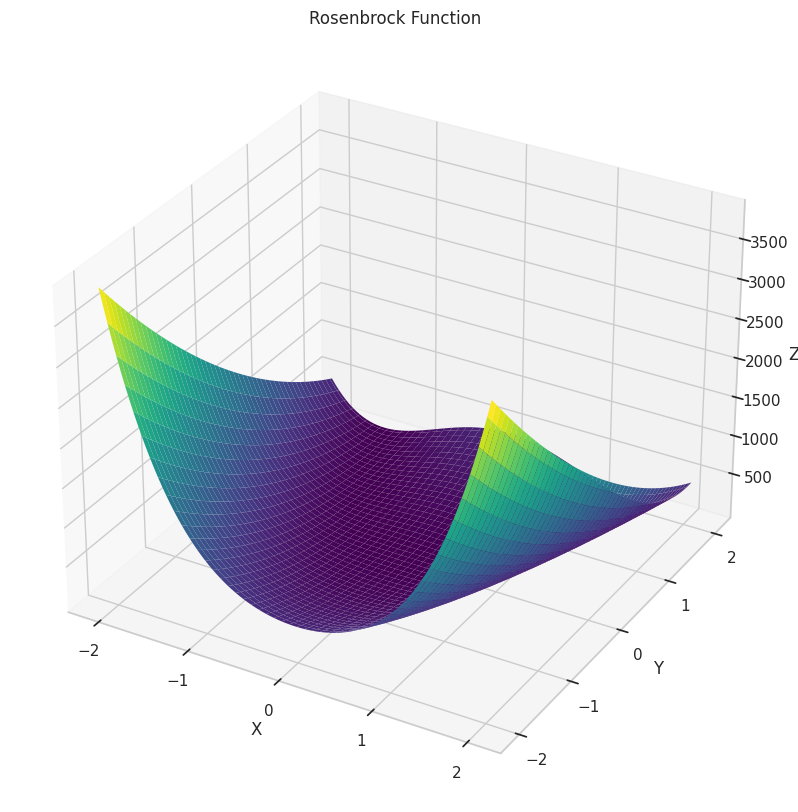

In [ ]:
def plot_3d_function(function, name):
        sns.set(style="whitegrid")
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')
        x = np.linspace(bounds[name][0], bounds[name][1], 100)
        y = np.linspace(bounds[name][0], bounds[name][1], 100)
        X, Y = np.meshgrid(x, y)
        Z = np.array([[function([x, y]) for x in x] for y in y])

        ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
        title = name + " Function"
        ax.set_title(title)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        plt.show()

plot_3d_function(ackley, "Ackley")
plot_3d_function(rastrigin, "Rastrigin")
plot_3d_function(schwefel, "Schwefel")
plot_3d_function(rosenbrock, "Rosenbrock")

## Algoritmo Genético

- Para o algoritmo genético, foram utilizados:
  - População de 100 indivíduos.
  - 30 dimensões.
  - Mutação Gaussiana, taxa de 25%.
  - One Point Crossover, taxa de 75%.
  - Seleção de parentes por Roleta.
  - Seleção de sobreviventes por Ranking de Fitness.
  - Taxa de natalidade de 25% por geração.
  - 500 gerações.

- Implementação do algoritmo genético que será utilizado para otimizar as funções selecionadas:

In [ ]:
class GA():
  # Função que inicializa uma permutação e calcula seu fitness
  def __init__(self, population_size, dimensions, function, bounds, max_generations, mutation_rate, crossover_rate, birth_rate):
    self.population_size = population_size
    self.dimensions = dimensions
    self.function = function
    self.bounds = bounds
    self.max_generations = max_generations
    self.mutation_rate = mutation_rate
    self.crossover_rate = crossover_rate
    self.population = self.generate_population()
    self.population_fitness = self.evaluate_population()
    self.birth_rate = birth_rate
    self.num_crossovers = int((self.population_size*self.birth_rate)//2)

  # Função que gera a população
  def generate_population(self):
    return (np.random.rand(self.population_size, self.dimensions) * (self.bounds[1] - self.bounds[0])) + self.bounds[0]

  # Função que acha os valores do fitness da população
  def evaluate_population(self):
    return np.array([self.function(individual) for individual in self.population])

  # Função que seleciona parentes
  def parent_selection(self):
    population_weights = [1/i for i in self.population_fitness]
    parent1, parent2 = random.choices(self.population, k=2, weights=population_weights)
    return parent1, parent2

  # Função que adiciona os filhos recém-nascidos e seleciona os sobreviventes na população
  def survivor_selection(self, offspring):
    new_population = []
    new_population = np.concatenate((self.population, offspring))
    sort_keys = np.array([self.function(i) for i in new_population])
    sorted_indices = np.argsort(sort_keys)
    new_population = new_population[sorted_indices]
    return new_population[:self.population_size]

  # Função que realiza mutação
  def mutate(self, individual, sigma=0.1):
    for i in range(self.dimensions):
        if random.random() < self.mutation_rate:
            individual[i] += random.gauss(0, sigma)
    return individual

  # Função que realiza recombinação
  def crossover(self, parent1, parent2):
    child1 = []
    child2 = []
    for i in range(self.dimensions):
        if random.random() < self.crossover_rate:
            child1.append(parent1[i])
            child2.append(parent2[i])
        else:
            child1.append(parent2[i])
            child2.append(parent1[i])
    return child1, child2

  # Função que roda o algoritmo e retorna os resultados para análise de múltiplas execuções
  def multiple_runs(self):
    best_fit = 0
    final_avgfit = 0
    iteration = 0

    while iteration < self.max_generations:
      newborns = []
      for i in range(self.num_crossovers):
        if random.random() < self.crossover_rate:
          parent1, parent2 = self.parent_selection()
          child1, child2 = self.crossover(parent1, parent2)
          child1 = self.mutate(child1)
          child2 = self.mutate(child2)
          newborns.extend([child1, child2])
      if len(newborns) > 0:
        self.population = self.survivor_selection(newborns)
        self.population_fitness = self.evaluate_population()
      iteration += 1

    best_fit = np.min(self.population_fitness)
    final_avgfit = np.average(self.population_fitness)

    return final_avgfit, best_fit

  # Função que roda o algoritmo e retorna os resultados para análise de uma única execução
  def single_run(self):
    iteration = 0
    best_fit_progress = []
    avg_fit_progress = []
    fit_std_progress = []

    while iteration < self.max_generations:
      newborns = []
      for i in range(self.num_crossovers):
        if random.random() < self.crossover_rate:
          parent1, parent2 = self.parent_selection()
          child1, child2 = self.crossover(parent1, parent2)
          child1 = self.mutate(child1)
          child2 = self.mutate(child2)
          newborns.extend([child1, child2])
      if len(newborns) > 0:
        self.population = self.survivor_selection(newborns)
        self.population_fitness = self.evaluate_population()
      iteration += 1
      best_fit_progress.append(np.min(self.population_fitness))
      avg_fit_progress.append(np.average(self.population_fitness))
      fit_std_progress.append(np.std(self.population_fitness))

    return best_fit_progress, avg_fit_progress, fit_std_progress

- Execução do algoritmo repetida 30 vezes utilizando os parâmetros dados.

In [ ]:
# Parâmetros que serão utilizados
pop_size = 100
mut_rate = 0.25
cross_rate = 0.75
birth_rate = 0.10

In [ ]:
# Obtenção dos dados para análise de 30 populações - Ackley
ackleyGA_avgfit = []
ackleyGA_bestfit = []
for i in range(executions):
  ackleyGA_m = GA(pop_size, dimensions, ackley, bounds["Ackley"], max_generations, mut_rate, cross_rate, birth_rate)
  final_avgfit, best_fit = ackleyGA_m.multiple_runs()
  ackleyGA_avgfit.append(final_avgfit)
  ackleyGA_bestfit.append(best_fit)

In [ ]:
# Obtenção dos dados para análise de 30 populações - Rastrigin
rastriginGA_avgfit = []
rastriginGA_bestfit = []
for i in range(executions):
  rastriginGA_m = GA(pop_size, dimensions, rastrigin, bounds["Rastrigin"], max_generations, mut_rate, cross_rate, birth_rate)
  final_avgfit, best_fit = rastriginGA_m.multiple_runs()
  rastriginGA_avgfit.append(final_avgfit)
  rastriginGA_bestfit.append(best_fit)

In [ ]:
# Obtenção dos dados para análise de 30 populações - Schwefel
schwefelGA_avgfit = []
schwefelGA_bestfit = []
for i in range(executions):
  schwefelGA_m = GA(pop_size, dimensions, schwefel, bounds["Schwefel"], max_generations, mut_rate, cross_rate, birth_rate)
  final_avgfit, best_fit = schwefelGA_m.multiple_runs()
  schwefelGA_avgfit.append(final_avgfit)
  schwefelGA_bestfit.append(best_fit)

In [ ]:
# Obtenção dos dados para análise de 30 populações - Rosenbrock
rosenbrockGA_avgfit = []
rosenbrockGA_bestfit = []
for i in range(executions):
  rosenbrockGA_m = GA(pop_size, dimensions, rosenbrock, bounds["Rosenbrock"], max_generations, mut_rate, cross_rate, birth_rate)
  final_avgfit, best_fit = rosenbrockGA_m.multiple_runs()
  rosenbrockGA_avgfit.append(final_avgfit)
  rosenbrockGA_bestfit.append(best_fit)

- Execução única do algoritmo para análise do progresso a cada iteração.

In [ ]:
# Obtenção dos dados para análise de uma população - Ackley
ackleyGA_s = GA(pop_size, dimensions, ackley, bounds["Ackley"], max_generations, mut_rate, cross_rate, birth_rate)
ackleyGA_bfp, ackleyGA_afp, ackleyGA_fsd = ackleyGA_s.single_run()

In [ ]:
# Obtenção dos dados para análise de uma população - Rastrigin
rastriginGA_s = GA(pop_size, dimensions, rastrigin, bounds["Rastrigin"], max_generations, mut_rate, cross_rate, birth_rate)
rastriginGA_bfp, rastriginGA_afp, rastriginGA_fsd = rastriginGA_s.single_run()

In [ ]:
# Obtenção dos dados para análise de uma população - Schwefel
schwefelGA_s = GA(pop_size, dimensions, schwefel, bounds["Schwefel"], max_generations, mut_rate, cross_rate, birth_rate)
schwefelGA_bfp, schwefelGA_afp, schwefelGA_fsd = schwefelGA_s.single_run()

In [ ]:
# Obtenção dos dados para análise de uma população - Rosenbrock
rosenbrockGA_s = GA(pop_size, dimensions, rosenbrock, bounds["Rosenbrock"], max_generations, mut_rate, cross_rate, birth_rate)
rosenbrockGA_bfp, rosenbrockGA_afp, rosenbrockGA_fsd = rosenbrockGA_s.single_run()

## Estratégia Evolutiva


- O código utiliza EE(lambda,mu), sendo mu = 30 e lambda = 7 * mu, o valor do sigma inicial é 3 e ele vai ajustando dinamicamente a cada iteração, ele tenta usar uma mutação CMA que durante a evolução, a matriz de covariância é ajustada com base no desempenho das soluções candidatas.

- Implementação da estratégia evolutiva que será utilizada para otimizar as funções selecionadas:

In [ ]:
class ES():
    def __init__(self, dimensions, function, bounds, mu, lambda_, max_generations, executions):
        self.dimensions = dimensions
        self.function = function
        self.bounds = bounds
        self.mu = mu
        self.lambda_ = lambda_
        self.max_generations = max_generations
        self.executions = executions

    def evaluate_population(self, Xs):
      return np.array([self.function(individual) for individual in Xs])

    def CMA_mutate(self, Xs, sigma, C, B, D):
        Z = np.random.randn(len(Xs))
        Y = np.dot(B, np.dot(D, Z))
        return Xs + sigma * Y

    def initialize_CMA_parameters(self, Xs):
        N = len(Xs)
        return np.eye(N), np.eye(N), np.eye(N)

    def ES_lambda_mu_step(self, parents, function, sigma, C, B, D):
        offspring = [self.CMA_mutate(parent, sigma, C, B, D) for parent in parents for _ in range(self.lambda_ // self.mu)]
        offspring.sort(key=lambda x: function(x))
        return offspring[:self.mu], offspring[0]

    def multiple_runs(self):
        final_avgfit_exec = []
        best_fitness_exec = []

        for _ in range(self.executions):
            Xs = np.random.uniform(self.bounds[0], self.bounds[1], size=(self.mu, self.dimensions))
            sigma = 10
            C, B, D = self.initialize_CMA_parameters(Xs[0])
            best_fitness = float('inf')

            for g in range(1, self.max_generations + 1):
                parents, best_offspring = self.ES_lambda_mu_step(Xs, self.function, sigma, C, B, D)
                current_fitness = self.function(best_offspring)
                best_fitness = min(best_fitness, current_fitness)
                sigma *= 1.9 if current_fitness < np.min(self.evaluate_population(Xs)) else 0.1
                sigma = max(0.1, min(sigma, 12.0))
                Xs = np.array(parents)

            pop_fitness = self.evaluate_population(Xs)
            final_avgfit_exec.append(np.average(pop_fitness))
            best_fitness_exec.append(np.min(pop_fitness))

        return final_avgfit_exec, best_fitness_exec

    def single_run(self):
        best_fit_progress = []
        avg_fit_progress = []
        fit_std_progress = []

        for _ in range(self.executions):
            Xs = np.random.uniform(self.bounds[0], self.bounds[1], size=(self.mu, self.dimensions))
            sigma = 10
            C, B, D = self.initialize_CMA_parameters(Xs[0])
            best_fitness = float('inf')

            for g in range(1, self.max_generations + 1):
                parents, best_offspring = self.ES_lambda_mu_step(Xs, self.function, sigma, C, B, D)
                current_fitness = self.function(best_offspring)
                best_fitness = min(best_fitness, current_fitness)
                sigma *= 1.9 if current_fitness < np.min(self.evaluate_population(Xs)) else 0.1
                sigma = max(0.1, min(sigma, 12.0))
                Xs = np.array(parents)

                pop_fitness = self.evaluate_population(Xs)
                best_fit_progress.append(np.min(pop_fitness))
                avg_fit_progress.append(np.average(pop_fitness))
                fit_std_progress.append(np.std(pop_fitness))

        return best_fit_progress, avg_fit_progress, fit_std_progress

- Execução do algoritmo repetida 30 vezes utilizando os parâmetros dados.

In [ ]:
# Parâmetros que serão utilizados
mu = 25
lambda_ = 5 * mu

In [ ]:
# Obtenção dos dados para análise de 30 populações - Ackley
ackleyES_m = ES(dimensions, ackley, bounds["Ackley"], mu, lambda_, max_generations, executions)
ackleyES_avgfit, ackleyES_bestfit = ackleyES_m.multiple_runs()

In [ ]:
# Obtenção dos dados para análise de 30 populações - Rastrigin
rastriginES_m = ES(dimensions, rastrigin, bounds["Rastrigin"], mu, lambda_, max_generations, executions)
rastriginES_avgfit, rastriginES_bestfit = rastriginES_m.multiple_runs()

In [ ]:
# Obtenção dos dados para análise de 30 populações - Schwefel
schwefelES_m = ES(dimensions, schwefel, bounds["Schwefel"], mu, lambda_, max_generations, executions)
schwefelES_avgfit, schwefelES_bestfit = schwefelES_m.multiple_runs()

In [ ]:
# Obtenção dos dados para análise de 30 populações - Rosenbrock
rosenbrockES_m = ES(dimensions, rosenbrock, bounds["Rosenbrock"], mu, lambda_, max_generations, executions)
rosenbrockES_avgfit, rosenbrockES_bestfit = rosenbrockES_m.multiple_runs()

- Execução única do algoritmo para análise do progresso a cada iteração.

In [ ]:
# Obtenção dos dados para análise de uma população - Ackley
ackleyES_s = ES(dimensions, ackley, bounds["Ackley"], mu, lambda_, max_generations, 1)
ackleyES_bfp, ackleyES_afp, ackleyES_fsd = ackleyES_s.single_run()

In [ ]:
# Obtenção dos dados para análise de uma população - Rastrigin
rastriginES_s = ES(dimensions, rastrigin, bounds["Rastrigin"], mu, lambda_, max_generations, 1)
rastriginES_bfp, rastriginES_afp, rastriginES_fsd = rastriginES_s.single_run()

In [ ]:
# Obtenção dos dados para análise de uma população - Schwefel
schwefelES_s = ES(dimensions, schwefel, bounds["Schwefel"], mu, lambda_, max_generations, 1)
schwefelES_bfp, schwefelES_afp, schwefelES_fsd = schwefelES_s.single_run()

In [ ]:
# Obtenção dos dados para análise de uma população - Rosenbrock
rosenbrockES_s = ES(dimensions, rosenbrock, bounds["Rosenbrock"], mu, lambda_, max_generations, 1)
rosenbrockES_bfp, rosenbrockES_afp, rosenbrockES_fsd = rosenbrockES_s.single_run()

## Algoritmos de Enxame

### CSA

In [ ]:
class CSA():
    def __init__(self, function, bounds, population_size, max_generations, executions, dimensions):
        self.function = function
        self.bounds = bounds
        self.population_size = population_size
        self.max_generations = max_generations
        self.executions = executions
        self.dimensions = dimensions

    def evaluate_population(self, Xs):
        return np.array([self.function(individual) for individual in Xs])

    def generate_initial_position(self):
        return np.random.uniform(self.bounds[0], self.bounds[1], (self.population_size, self.dimensions))

    def multiple_runs(self):
        final_avgfit_exec = []
        best_fitness_exec = []

        for _ in range(self.executions):
            max_generations = self.max_generations
            t = 1
            AP = 0.5  # Awareness Probability
            fl = 2  # Flight Length
            N = self.population_size
            xi = self.generate_initial_position()
            mi = xi.copy()

            while t <= max_generations:
                j = np.random.randint(N)
                ri = np.random.uniform(0, 1, self.dimensions)
                for i in range(N):
                    if np.random.uniform(0, 1) >= AP:
                        xi_new = xi[i] + ri * fl * (mi[j] - xi[i])
                    else:
                        xi_new = np.random.uniform(self.bounds[0], self.bounds[1], self.dimensions)
                    xi_new = np.clip(xi_new, self.bounds[0], self.bounds[1])
                if self.function(xi_new) < self.function(mi[i]):
                    mi[i] = xi_new

            pop_fitness = self.evaluate_population(mi)
            final_avgfit_exec.append(np.average(pop_fitness))
            best_fitness_exec.append(np.min(pop_fitness))

        return final_avgfit_exec, best_fitness_exec

    def single_run(self):
        best_fit_progress = []
        avg_fit_progress = []
        fit_std_progress = []

        max_generations = self.max_generations

        t = 1
        AP = 0.5  # Awareness Probability
        fl = 2  # Flight Length
        N = self.population_size
        xi = self.generate_initial_position()
        mi = xi.copy()

        while t <= max_generations:
            j = np.random.randint(N)
            ri = np.random.uniform(0, 1, self.dimensions)
            for i in range(N):
                if np.random.uniform(0, 1) >= AP:
                    xi_new = xi[i] + ri * fl * (mi[j] - xi[i])
                else:
                    xi_new = np.random.uniform(self.bounds[0], self.bounds[1], self.dimensions)
                xi_new = np.clip(xi_new, self.bounds[0], self.bounds[1])
            if self.function(xi_new) < self.function(mi[i]):
                mi[i] = xi_new

            pop_fitness = self.evaluate_population(mi)
            best_fit_progress.append(np.min(pop_fitness))
            avg_fit_progress.append(np.average(pop_fitness))
            fit_std_progress.append(np.std(pop_fitness))

        return best_fit_progress, avg_fit_progress, fit_std_progress

- Execução do algoritmo repetida 30 vezes utilizando os parâmetros dados.

In [ ]:
# Parâmetros para o CSA e variantes
pop_sizeCSA = 20

In [ ]:
# Obtenção dos dados para análise de 30 populações - Ackley
ackleyCSA_m = CSA(ackley, bounds["Ackley"], pop_sizeCSA, max_generations, executions, dimensions)
ackleyCSA_avgfit, ackleyCSA_bestfit = ackleyCSA_m.multiple_runs()

In [ ]:
# Obtenção dos dados para análise de 30 populações - Rastrigin
rastriginCSA_m = CSA(rastrigin, bounds["Rastrigin"], pop_sizeCSA, max_generations, executions, dimensions)
rastriginCSA_avgfit, rastriginCSA_bestfit = rastriginCSA_m.multiple_runs()

In [ ]:
# Obtenção dos dados para análise de 30 populações - Schwefel
schwefelCSA_m = CSA(schwefel, bounds["Schwefel"], pop_sizeCSA, max_generations, executions, dimensions)
schwefelCSA_avgfit, schwefelCSA_bestfit = schwefelCSA_m.multiple_runs()

In [ ]:
# Obtenção dos dados para análise de 30 populações - Rosenbrock
rosenbrockCSA_m = CSA(rosenbrock, bounds["Rosenbrock"], pop_sizeCSA, max_generations, executions, dimensions)
rosenbrockCSA_avgfit, rosenbrockCSA_bestfit = rosenbrockCSA_m.multiple_runs()

- Execução única do algoritmo para análise do progresso a cada iteração.

In [ ]:
# Obtenção dos dados para análise de uma população - Ackley
ackleyCSA_s = CSA(ackley, bounds["Ackley"], pop_sizeCSA, max_generations, 1, dimensions)
ackleyCSA_bfp, ackleyCSA_afp, ackleyCSA_fsd = ackleyCSA_s.single_run()

In [ ]:
# Obtenção dos dados para análise de uma população - Rastrigin
rastriginCSA_s = CSA(rastrigin, bounds["Rastrigin"], pop_sizeCSA, max_generations, 1, dimensions)
rastriginCSA_bfp, rastriginCSA_afp, rastriginCSA_fsd = rastriginCSA_s.single_run()

In [ ]:
# Obtenção dos dados para análise de uma população - Schwefel
schwefelCSA_s = CSA(schwefel, bounds["Schwefel"], pop_sizeCSA, max_generations, 1, dimensions)
schwefelCSA_bfp, schwefelCSA_afp, schwefelCSA_fsd = schwefelCSA_s.single_run()

In [ ]:
# Obtenção dos dados para análise de uma população - Rosenbrock
rosenbrockCSA_s = CSA(rosenbrock, bounds["Rosenbrock"], pop_sizeCSA, max_generations, 1, dimensions)
rosenbrockCSA_bfp, rosenbrockCSA_afp, rosenbrockCSA_fsd = rosenbrockCSA_s.single_run()

### Advanced CSA

In [ ]:
class ACSA():
    def __init__(self, function, bounds, population_size, max_generations, executions, dimensions):
        self.function = function
        self.bounds = bounds
        self.population_size = population_size
        self.max_generations = max_generations
        self.executions = executions
        self.dimensions = dimensions

    def evaluate_population(self, Xs):
        return np.array([self.function(individual) for individual in Xs])

    def initialize_parameters(self):
        APmax = 0.6
        APmin = 0.4
        FAR = 0.2
        fl = 2.0
        N = 40
        pd = 0.5
        tmax = 200
        return APmax, APmin, FAR, fl, N, pd, tmax

    def initialize_positions(self):
        return np.random.uniform(self.bounds[0], self.bounds[1], (self.population_size, self.dimensions))

    def multiple_runs(self):
        final_avgfit_exec = []
        best_fitness_exec = []

        for _ in range(self.executions):
            APmax, APmin, FAR, fl, N, pd, tmax = self.initialize_parameters()
            max_generations = self.max_generations
            t = 1
            xi = self.initialize_positions()
            mi = xi.copy()

            while t <= max_generations:
                for i in range(self.population_size):  # Corrigindo aqui para iterar até self.population_size
                    r1 = np.random.uniform(0, 1)
                    r2 = np.random.uniform(0, 1)
                    r3 = np.random.uniform(0, 1)
                    r4 = np.random.uniform(0, 1)
                    r5 = np.random.uniform(0, 1)

                    if r1 >= APmax:
                        if r3 <= FAR:
                            xi_new = xi[i] + r2 * fl * (mi[i] - xi[i])
                        else:
                            xi_new = xi[i] + r2 * fl * (mi[-1] - xi[i])
                    else:
                        if r4 <= pd:
                            xi_new = 2 * xi[i] + (self.bounds[0] + r5 * (self.bounds[0] - self.bounds[1])) / t
                        else:
                            xi_new = np.random.uniform(self.bounds[0], self.bounds[1], self.dimensions)

                    xi_new = np.clip(xi_new, self.bounds[0], self.bounds[1])
                    if self.function(xi_new) < self.function(mi[i]):
                        mi[i] = xi_new

            pop_fitness = self.evaluate_population(mi)
            final_avgfit_exec.append(np.average(pop_fitness))
            best_fitness_exec.append(np.min(pop_fitness))

        return final_avgfit_exec, best_fitness_exec

    def single_run(self):
        best_fit_progress = []
        avg_fit_progress = []
        fit_std_progress = []

        for _ in range(self.executions):
            APmax, APmin, FAR, fl, N, pd, tmax = self.initialize_parameters()
            max_generations = self.max_generations
            t = 1
            xi = self.initialize_positions()
            mi = xi.copy()

            while t <= max_generations:
                for i in range(self.population_size):  # Corrigindo aqui para iterar até self.population_size
                    r1 = np.random.uniform(0, 1)
                    r2 = np.random.uniform(0, 1)
                    r3 = np.random.uniform(0, 1)
                    r4 = np.random.uniform(0, 1)
                    r5 = np.random.uniform(0, 1)

                    if r1 >= APmax:
                        if r3 <= FAR:
                            xi_new = xi[i] + r2 * fl * (mi[i] - xi[i])
                        else:
                            xi_new = xi[i] + r2 * fl * (mi[-1] - xi[i])
                    else:
                        if r4 <= pd:
                            xi_new = 2 * xi[i] + (self.bounds[0] + r5 * (self.bounds[0] - self.bounds[1])) / t
                        else:
                            xi_new = np.random.uniform(self.bounds[0], self.bounds[1], self.dimensions)

                    xi_new = np.clip(xi_new, self.bounds[0], self.bounds[1])
                    if self.function(xi_new) < self.function(mi[i]):
                        mi[i] = xi_new

                pop_fitness = self.evaluate_population(mi)
                best_fit_progress.append(np.min(pop_fitness))
                avg_fit_progress.append(np.average(pop_fitness))
                fit_std_progress.append(np.std(pop_fitness))

        return best_fit_progress, avg_fit_progress, fit_std_progress

- Execução do algoritmo repetida 30 vezes utilizando os parâmetros dados.

In [ ]:
# Obtenção dos dados para análise de 30 populações - Ackley
ackleyACSA_m = ACSA(ackley, bounds["Ackley"], pop_sizeCSA, max_generations, executions, dimensions)
ackleyACSA_avgfit, ackleyACSA_bestfit = ackleyACSA_m.multiple_runs()

In [ ]:
# Obtenção dos dados para análise de 30 populações - Rastrigin
rastriginACSA_m = ACSA(rastrigin, bounds["Rastrigin"], pop_sizeCSA, max_generations, executions, dimensions)
rastriginACSA_avgfit, rastriginACSA_bestfit = rastriginACSA_m.multiple_runs()

In [ ]:
# Obtenção dos dados para análise de 30 populações - Schwefel
schwefelACSA_m = ACSA(schwefel, bounds["Schwefel"], pop_sizeCSA, max_generations, executions, dimensions)
schwefelACSA_avgfit, schwefelACSA_bestfit = schwefelACSA_m.multiple_runs()

In [ ]:
# Obtenção dos dados para análise de 30 populações - Rosenbrock
rosenbrockACSA_m = ACSA(rosenbrock, bounds["Rosenbrock"], pop_sizeCSA, max_generations, executions, dimensions)
rosenbrockACSA_avgfit, rosenbrockACSA_bestfit = rosenbrockACSA_m.multiple_runs()

- Execução única do algoritmo para análise do progresso a cada iteração.

In [ ]:
# Obtenção dos dados para análise de uma população - Ackley
ackleyACSA_s = ACSA(ackley, bounds["Ackley"], pop_sizeCSA, max_generations, 1, dimensions)
ackleyACSA_bfp, ackleyACSA_afp, ackleyACSA_fsd = ackleyACSA_s.single_run()

In [ ]:
# Obtenção dos dados para análise de uma população - Rastrigin
rastriginACSA_s = ACSA(rastrigin, bounds["Rastrigin"], pop_sizeCSA, max_generations, 1, dimensions)
rastriginACSA_bfp, rastriginACSA_afp, rastriginACSA_fsd = rastriginACSA_s.single_run()

In [ ]:
# Obtenção dos dados para análise de uma população - Schwefel
schwefelACSA_s = ACSA(schwefel, bounds["Schwefel"], pop_sizeCSA, max_generations, 1, dimensions)
schwefelACSA_bfp, schwefelACSA_afp, schwefelACSA_fsd = schwefelACSA_s.single_run()

In [ ]:
# Obtenção dos dados para análise de uma população - Rosenbrock
rosenbrockACSA_s = ACSA(rosenbrock, bounds["Rosenbrock"], pop_sizeCSA, max_generations, 1, dimensions)
rosenbrockACSA_bfp, rosenbrockACSA_afp, rosenbrockACSA_fsd = rosenbrockACSA_s.single_run()

### Variable Step CSA

In [ ]:
class VSCSA():
    def __init__(self, function, bounds, population_size, max_generations, executions, dimensions):
        self.function = function
        self.bounds = bounds
        self.population_size = population_size
        self.max_generations = max_generations
        self.executions = executions
        self.dimensions = dimensions

    def evaluate_population(self, Xs):
        return np.array([self.function(individual) for individual in Xs])

    def initialize_parameters(self):
        tmax = self.max_generations
        AP = 0.5  # Awareness Probability
        N = self.population_size
        return tmax, AP, N

    def generate_initial_position(self, N):
        return np.random.uniform(self.bounds[0], self.bounds[1], (N, self.dimensions))

    def multiple_runs(self):
        final_avgfit_exec = []
        best_fitness_exec = []

        for _ in range(self.executions):
            tmax, AP, N = self.initialize_parameters()
            xi = self.generate_initial_position(N)
            mi = xi.copy()

            for _ in range(tmax):
                for i in range(N):
                    j = np.random.randint(N)
                    ri = np.random.uniform(0, 1, self.dimensions)
                    if np.random.uniform(0, 1) >= AP:
                        xi_new = xi[i] + np.abs(np.cos(ri)) * (mi[j] - xi[i])
                    else:
                        xi_new = 0.1 * (0.001 * np.random.rand(self.dimensions) + mi[j])
                    xi_new = np.clip(xi_new, self.bounds[0], self.bounds[1])
                    if self.function(xi_new) < self.function(mi[i]):
                        mi[i] = xi_new

            pop_fitness = self.evaluate_population(mi)
            final_avgfit_exec.append(np.average(pop_fitness))
            best_fitness_exec.append(np.min(pop_fitness))

        return final_avgfit_exec, best_fitness_exec

    def single_run(self):
        best_fit_progress = []
        avg_fit_progress = []
        fit_std_progress = []

        tmax, AP, N = self.initialize_parameters()
        xi = self.generate_initial_position(N)
        mi = xi.copy()

        for _ in range(tmax):
            for i in range(N):
                j = np.random.randint(N)
                ri = np.random.uniform(0, 1, self.dimensions)
                if np.random.uniform(0, 1) >= AP:
                    xi_new = xi[i] + np.abs(np.cos(ri)) * (mi[j] - xi[i])
                else:
                    xi_new = 0.1 * (0.001 * np.random.rand(self.dimensions) + mi[j])
                xi_new = np.clip(xi_new, self.bounds[0], self.bounds[1])
                if self.function(xi_new) < self.function(mi[i]):
                    mi[i] = xi_new

            pop_fitness = self.evaluate_population(mi)
            best_fit_progress.append(np.min(pop_fitness))
            avg_fit_progress.append(np.average(pop_fitness))
            fit_std_progress.append(np.std(pop_fitness))

        return best_fit_progress, avg_fit_progress, fit_std_progress

- Execução do algoritmo repetida 30 vezes utilizando os parâmetros dados.

In [ ]:
# Obtenção dos dados para análise de 30 populações - Ackley
ackleyVSCSA_m = VSCSA(ackley, bounds["Ackley"], pop_sizeCSA, max_generations, executions, dimensions)
ackleyVSCSA_avgfit, ackleyVSCSA_bestfit = ackleyVSCSA_m.multiple_runs()

In [ ]:
# Obtenção dos dados para análise de 30 populações - Rastrigin
rastriginVSCSA_m = VSCSA(rastrigin, bounds["Rastrigin"], pop_sizeCSA, max_generations, executions, dimensions)
rastriginVSCSA_avgfit, rastriginVSCSA_bestfit = rastriginVSCSA_m.multiple_runs()

In [ ]:
# Obtenção dos dados para análise de 30 populações - Schwefel
schwefelVSCSA_m = VSCSA(schwefel, bounds["Schwefel"], pop_sizeCSA, max_generations, executions, dimensions)
schwefelVSCSA_avgfit, schwefelVSCSA_bestfit = schwefelVSCSA_m.multiple_runs()

In [ ]:
# Obtenção dos dados para análise de 30 populações - Rosenbrock
rosenbrockVSCSA_m = VSCSA(rosenbrock, bounds["Rosenbrock"], pop_sizeCSA, max_generations, executions, dimensions)
rosenbrockVSCSA_avgfit, rosenbrockVSCSA_bestfit = rosenbrockVSCSA_m.multiple_runs()

- Execução única do algoritmo para análise do progresso a cada iteração.

In [ ]:
# Obtenção dos dados para análise de uma população - Ackley
ackleyVSCSA_s = VSCSA(ackley, bounds["Ackley"], pop_sizeCSA, max_generations, 1, dimensions)
ackleyVSCSA_bfp, ackleyVSCSA_afp, ackleyVSCSA_fsd = ackleyVSCSA_s.single_run()

In [ ]:
# Obtenção dos dados para análise de uma população - Rastrigin
rastriginVSCSA_s = VSCSA(rastrigin, bounds["Rastrigin"], pop_sizeCSA, max_generations, 1, dimensions)
rastriginVSCSA_bfp, rastriginVSCSA_afp, rastriginVSCSA_fsd = rastriginVSCSA_s.single_run()

In [ ]:
# Obtenção dos dados para análise de uma população - Schwefel
schwefelVSCSA_s = VSCSA(schwefel, bounds["Schwefel"], pop_sizeCSA, max_generations, 1, dimensions)
schwefelVSCSA_bfp, schwefelVSCSA_afp, schwefelVSCSA_fsd = schwefelVSCSA_s.single_run()

In [ ]:
# Obtenção dos dados para análise de uma população - Rosenbrock
rosenbrockVSCSA_s = VSCSA(rosenbrock, bounds["Rosenbrock"], pop_sizeCSA, max_generations, 1, dimensions)
rosenbrockVSCSA_bfp, rosenbrockVSCSA_afp, rosenbrockVSCSA_fsd = rosenbrockVSCSA_s.single_run()

## Análise dos dados

### Análise de 30 populações

- Melhor Fitness

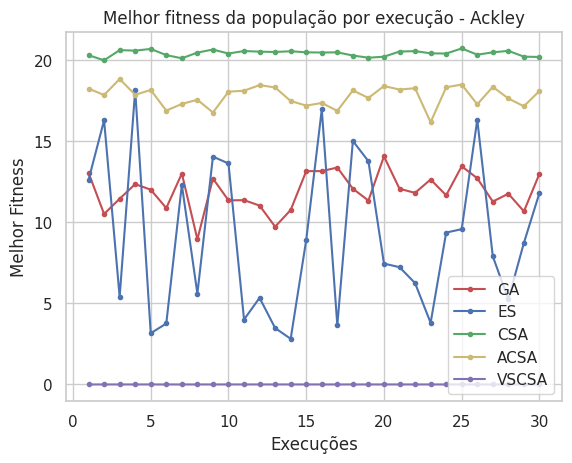

In [ ]:
plt.plot(range(1, executions+1), ackleyGA_bestfit, marker='.', linestyle='-', color='r', label='GA')
plt.plot(range(1, executions+1), ackleyES_bestfit, marker='.', linestyle='-', color='b', label='ES')
plt.plot(range(1, executions+1), ackleyCSA_bestfit, marker='.', linestyle='-', color='g', label='CSA')
plt.plot(range(1, executions+1), ackleyACSA_bestfit, marker='.', linestyle='-', color='y', label='ACSA')
plt.plot(range(1, executions+1), ackleyVSCSA_bestfit, marker='.', linestyle='-', color='m', label='VSCSA')
plt.title('Melhor fitness da população por execução - Ackley')
plt.xlabel('Execuções')
plt.ylabel('Melhor Fitness')
plt.legend()
plt.show()

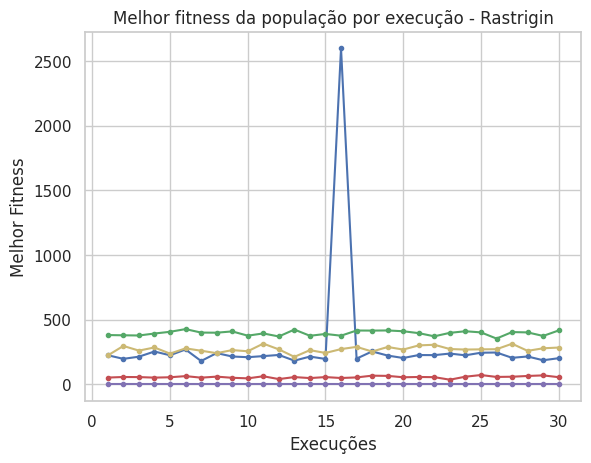

In [ ]:
plt.plot(range(1, executions+1), rastriginGA_bestfit, marker='.', linestyle='-', color='r', label='GA')
plt.plot(range(1, executions+1), rastriginES_bestfit, marker='.', linestyle='-', color='b', label='ES')
plt.plot(range(1, executions+1), rastriginCSA_bestfit, marker='.', linestyle='-', color='g', label='CSA')
plt.plot(range(1, executions+1), rastriginACSA_bestfit, marker='.', linestyle='-', color='y', label='ACSA')
plt.plot(range(1, executions+1), rastriginVSCSA_bestfit, marker='.', linestyle='-', color='m', label='VSCSA')
plt.title('Melhor fitness da população por execução - Rastrigin')
plt.xlabel('Execuções')
plt.ylabel('Melhor Fitness')
plt.show()

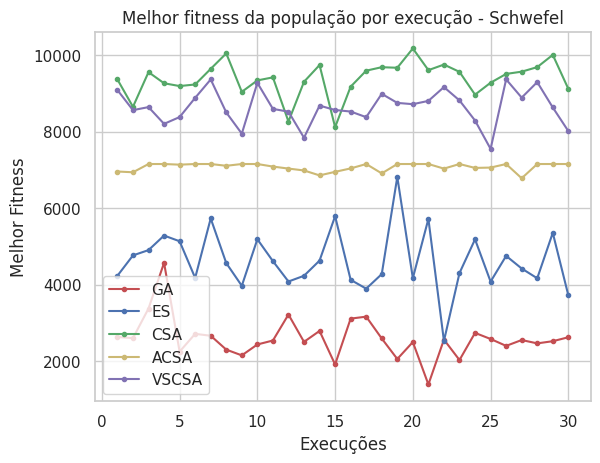

In [ ]:
plt.plot(range(1, executions+1), schwefelGA_bestfit, marker='.', linestyle='-', color='r', label='GA')
plt.plot(range(1, executions+1), schwefelES_bestfit, marker='.', linestyle='-', color='b', label='ES')
plt.plot(range(1, executions+1), schwefelCSA_bestfit, marker='.', linestyle='-', color='g', label='CSA')
plt.plot(range(1, executions+1), schwefelACSA_bestfit, marker='.', linestyle='-', color='y', label='ACSA')
plt.plot(range(1, executions+1), schwefelVSCSA_bestfit, marker='.', linestyle='-', color='m', label='VSCSA')
plt.title('Melhor fitness da população por execução - Schwefel')
plt.xlabel('Execuções')
plt.ylabel('Melhor Fitness')
plt.legend()
plt.show()

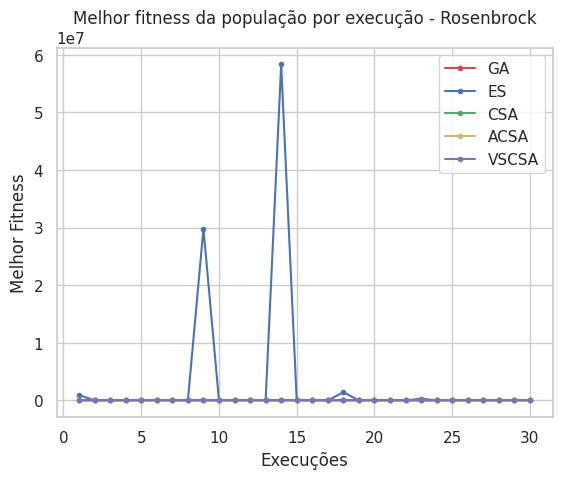

In [ ]:
plt.plot(range(1, executions+1), rosenbrockGA_bestfit, marker='.', linestyle='-', color='r', label='GA')
plt.plot(range(1, executions+1), rosenbrockES_bestfit, marker='.', linestyle='-', color='b', label='ES')
plt.plot(range(1, executions+1), rosenbrockCSA_bestfit, marker='.', linestyle='-', color='g', label='CSA')
plt.plot(range(1, executions+1), rosenbrockACSA_bestfit, marker='.', linestyle='-', color='y', label='ACSA')
plt.plot(range(1, executions+1), rosenbrockVSCSA_bestfit, marker='.', linestyle='-', color='m', label='VSCSA')
plt.title('Melhor fitness da população por execução - Rosenbrock')
plt.xlabel('Execuções')
plt.ylabel('Melhor Fitness')
plt.legend()
plt.show()

In [ ]:
print("Melhor Fitness do GA nas", executions, "execuções - Ackley:", np.min(ackleyGA_bestfit))
print("Melhor Fitness do ES nas", executions, "execuções - Ackley:", np.min(ackleyES_bestfit))
print("Melhor Fitness do CSA nas", executions, "execuções - Ackley:", np.min(ackleyCSA_bestfit))
print("Melhor Fitness do ACSA nas", executions, "execuções - Ackley:", np.min(ackleyACSA_bestfit))
print("Melhor Fitness do VSCSA nas", executions, "execuções - Ackley:", np.min(ackleyVSCSA_bestfit))

Melhor Fitness do GA nas 30 execuções - Ackley: 8.945329246550019
Melhor Fitness do ES nas 30 execuções - Ackley: 2.811566268404548
Melhor Fitness do CSA nas 30 execuções - Ackley: 19.970867060687898
Melhor Fitness do ACSA nas 30 execuções - Ackley: 16.15769285536371
Melhor Fitness do VSCSA nas 30 execuções - Ackley: 0.00015271668130667493


In [ ]:
print("Melhor Fitness do GA nas", executions, "execuções - Rastrigin:", np.min(rastriginGA_bestfit))
print("Melhor Fitness do ES nas", executions, "execuções - Rastrigin:", np.min(rastriginES_bestfit))
print("Melhor Fitness do CSA nas", executions, "execuções - Rastrigin:", np.min(rastriginCSA_bestfit))
print("Melhor Fitness do ACSA nas", executions, "execuções - Rastrigin:", np.min(rastriginACSA_bestfit))
print("Melhor Fitness do VSCSA nas", executions, "execuções - Rastrigin:", np.min(rastriginVSCSA_bestfit))

Melhor Fitness do GA nas 30 execuções - Rastrigin: 36.72150539778653
Melhor Fitness do ES nas 30 execuções - Rastrigin: 181.17218351389434
Melhor Fitness do CSA nas 30 execuções - Rastrigin: 354.5787132854649
Melhor Fitness do ACSA nas 30 execuções - Rastrigin: 213.1604186545224
Melhor Fitness do VSCSA nas 30 execuções - Rastrigin: 8.774090986207739e-06


In [ ]:
print("Melhor Fitness do GA nas", executions, "execuções - Schwefel:", np.min(schwefelGA_bestfit))
print("Melhor Fitness do ES nas", executions, "execuções - Schwefel:", np.min(schwefelES_bestfit))
print("Melhor Fitness do CSA nas", executions, "execuções - Schwefel:", np.min(schwefelCSA_bestfit))
print("Melhor Fitness do ACSA nas", executions, "execuções - Schwefel:", np.min(schwefelACSA_bestfit))
print("Melhor Fitness do VSCSA nas", executions, "execuções - Schwefel:", np.min(schwefelVSCSA_bestfit))

Melhor Fitness do GA nas 30 execuções - Schwefel: 1395.434492020173
Melhor Fitness do ES nas 30 execuções - Schwefel: 2531.1804408659937
Melhor Fitness do CSA nas 30 execuções - Schwefel: 8115.106461372198
Melhor Fitness do ACSA nas 30 execuções - Schwefel: 6779.70601785806
Melhor Fitness do VSCSA nas 30 execuções - Schwefel: 7547.088736916511


In [ ]:
print("Melhor Fitness do GA nas", executions, "execuções - Rosenbrock:", np.min(rosenbrockGA_bestfit))
print("Melhor Fitness do ES nas", executions, "execuções - Rosenbrock:", np.min(rosenbrockES_bestfit))
print("Melhor Fitness do CSA nas", executions, "execuções - Rosenbrock:", np.min(rosenbrockCSA_bestfit))
print("Melhor Fitness do ACSA nas", executions, "execuções - Rosenbrock:", np.min(rosenbrockACSA_bestfit))
print("Melhor Fitness do VSCSA nas", executions, "execuções - Rosenbrock:", np.min(rosenbrockVSCSA_bestfit))

Melhor Fitness do GA nas 30 execuções - Rosenbrock: 60.844253150580215
Melhor Fitness do ES nas 30 execuções - Rosenbrock: 1226.081547872612
Melhor Fitness do CSA nas 30 execuções - Rosenbrock: 2768.753696862402
Melhor Fitness do ACSA nas 30 execuções - Rosenbrock: 732.646492293384
Melhor Fitness do VSCSA nas 30 execuções - Rosenbrock: 28.947426025042965


- Fitness Médio

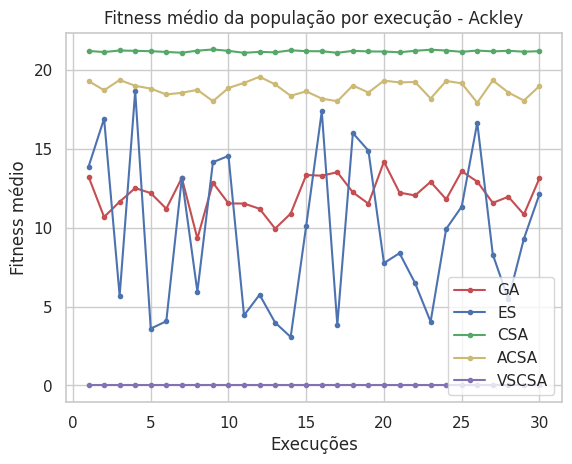

In [ ]:
plt.plot(range(1, executions+1), ackleyGA_avgfit, marker='.', linestyle='-', color='r', label='GA')
plt.plot(range(1, executions+1), ackleyES_avgfit, marker='.', linestyle='-', color='b', label='ES')
plt.plot(range(1, executions+1), ackleyCSA_avgfit, marker='.', linestyle='-', color='g', label='CSA')
plt.plot(range(1, executions+1), ackleyACSA_avgfit, marker='.', linestyle='-', color='y', label='ACSA')
plt.plot(range(1, executions+1), ackleyVSCSA_avgfit, marker='.', linestyle='-', color='m', label='VSCSA')
plt.title('Fitness médio da população por execução - Ackley')
plt.xlabel('Execuções')
plt.ylabel('Fitness médio')
plt.legend()
plt.show()

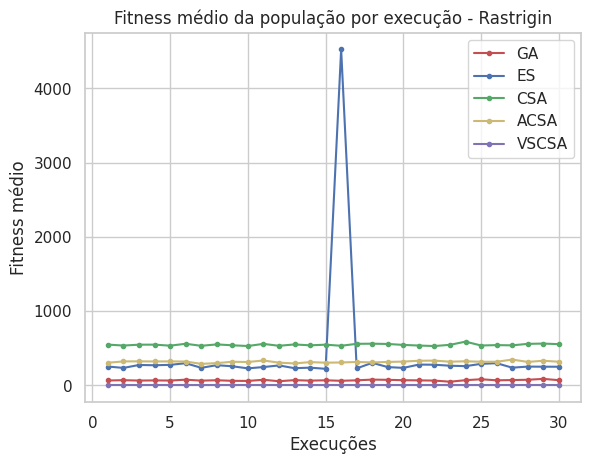

In [ ]:
plt.plot(range(1, executions+1), rastriginGA_avgfit, marker='.', linestyle='-', color='r', label='GA')
plt.plot(range(1, executions+1), rastriginES_avgfit, marker='.', linestyle='-', color='b', label='ES')
plt.plot(range(1, executions+1), rastriginCSA_avgfit, marker='.', linestyle='-', color='g', label='CSA')
plt.plot(range(1, executions+1), rastriginACSA_avgfit, marker='.', linestyle='-', color='y', label='ACSA')
plt.plot(range(1, executions+1), rastriginVSCSA_avgfit, marker='.', linestyle='-', color='m', label='VSCSA')
plt.title('Fitness médio da população por execução - Rastrigin')
plt.xlabel('Execuções')
plt.ylabel('Fitness médio')
plt.legend()
plt.show()

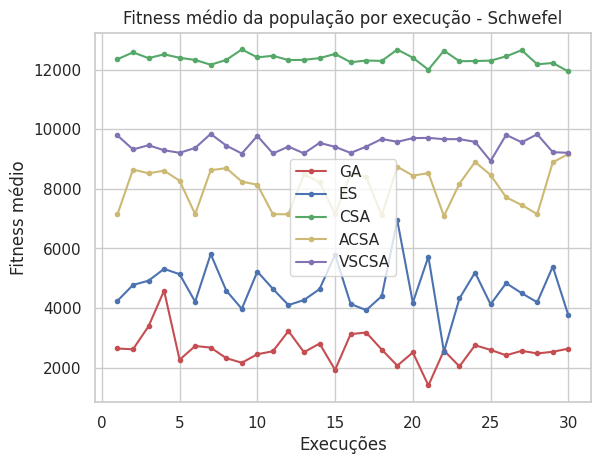

In [ ]:
plt.plot(range(1, executions+1), schwefelGA_avgfit, marker='.', linestyle='-', color='r', label='GA')
plt.plot(range(1, executions+1), schwefelES_avgfit, marker='.', linestyle='-', color='b', label='ES')
plt.plot(range(1, executions+1), schwefelCSA_avgfit, marker='.', linestyle='-', color='g', label='CSA')
plt.plot(range(1, executions+1), schwefelACSA_avgfit, marker='.', linestyle='-', color='y', label='ACSA')
plt.plot(range(1, executions+1), schwefelVSCSA_avgfit, marker='.', linestyle='-', color='m', label='VSCSA')
plt.title('Fitness médio da população por execução - Schwefel')
plt.xlabel('Execuções')
plt.ylabel('Fitness médio')
plt.show()

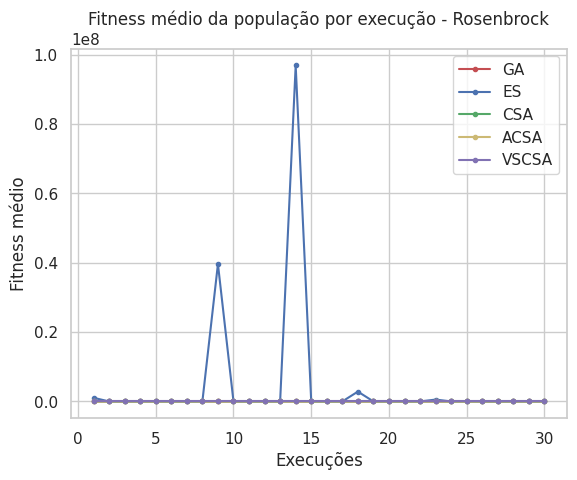

In [ ]:
plt.plot(range(1, executions+1), rosenbrockGA_avgfit, marker='.', linestyle='-', color='r', label='GA')
plt.plot(range(1, executions+1), rosenbrockES_avgfit, marker='.', linestyle='-', color='b', label='ES')
plt.plot(range(1, executions+1), rosenbrockCSA_avgfit, marker='.', linestyle='-', color='g', label='CSA')
plt.plot(range(1, executions+1), rosenbrockACSA_avgfit, marker='.', linestyle='-', color='y', label='ACSA')
plt.plot(range(1, executions+1), rosenbrockVSCSA_avgfit, marker='.', linestyle='-', color='m', label='VSCSA')
plt.title('Fitness médio da população por execução - Rosenbrock')
plt.xlabel('Execuções')
plt.ylabel('Fitness médio')
plt.legend()
plt.show()

In [ ]:
print("Média do Fitness Médio do GA nas", executions, "execuções - Ackley:", np.average(ackleyGA_avgfit))
print("Média do Fitness Médio do ES nas", executions, "execuções - Ackley:", np.average(ackleyES_avgfit))
print("Média do Fitness Médio do CSA nas", executions, "execuções - Ackley:", np.average(ackleyCSA_avgfit))
print("Média do Fitness Médio do ACSA nas", executions, "execuções - Ackley:", np.average(ackleyACSA_avgfit))
print("Média do Fitness Médio do VSCSA nas", executions, "execuções - Ackley:", np.average(ackleyVSCSA_avgfit))

Média do Fitness Médio do GA nas 30 execuções - Ackley: 12.099060987778218
Média do Fitness Médio do ES nas 30 execuções - Ackley: 9.660097255516812
Média do Fitness Médio do CSA nas 30 execuções - Ackley: 21.182189647651683
Média do Fitness Médio do ACSA nas 30 execuções - Ackley: 18.78873401698495
Média do Fitness Médio do VSCSA nas 30 execuções - Ackley: 0.00018822505853547018


In [ ]:
print("Média do Fitness Médio do GA nas", executions, "execuções - Rastrigin:", np.average(rastriginGA_avgfit))
print("Média do Fitness Médio do ES nas", executions, "execuções - Rastrigin:", np.average(rastriginES_avgfit))
print("Média do Fitness Médio do CSA nas", executions, "execuções - Rastrigin:", np.average(rastriginCSA_avgfit))
print("Média do Fitness Médio do ACSA nas", executions, "execuções - Rastrigin:", np.average(rastriginACSA_avgfit))
print("Média do Fitness Médio do VSCSA nas", executions, "execuções - Rastrigin:", np.average(rastriginVSCSA_avgfit))

Média do Fitness Médio do GA nas 30 execuções - Rastrigin: 69.50785286025757
Média do Fitness Médio do ES nas 30 execuções - Rastrigin: 401.4187088562265
Média do Fitness Médio do CSA nas 30 execuções - Rastrigin: 548.0447825700679
Média do Fitness Médio do ACSA nas 30 execuções - Rastrigin: 318.34217871015454
Média do Fitness Médio do VSCSA nas 30 execuções - Rastrigin: 1.3178845130615477e-05


In [ ]:
print("Média do Fitness Médio do GA nas", executions, "execuções - Schwefel:", np.average(schwefelGA_avgfit))
print("Média do Fitness Médio do ES nas", executions, "execuções - Schwefel:", np.average(schwefelES_avgfit))
print("Média do Fitness Médio do CSA nas", executions, "execuções - Schwefel:", np.average(schwefelCSA_avgfit))
print("Média do Fitness Médio do ACSA nas", executions, "execuções - Schwefel:", np.average(schwefelACSA_avgfit))
print("Média do Fitness Médio do VSCSA nas", executions, "execuções - Schwefel:", np.average(schwefelVSCSA_avgfit))

Média do Fitness Médio do GA nas 30 execuções - Schwefel: 2609.1287509295294
Média do Fitness Médio do ES nas 30 execuções - Schwefel: 4658.46575244912
Média do Fitness Médio do CSA nas 30 execuções - Schwefel: 12368.185500354697
Média do Fitness Médio do ACSA nas 30 execuções - Schwefel: 8097.6358816321035
Média do Fitness Médio do VSCSA nas 30 execuções - Schwefel: 9474.365862538185


In [ ]:
print("Média do Fitness Médio do GA nas", executions, "execuções - Rosenbrock:", np.average(rosenbrockGA_avgfit))
print("Média do Fitness Médio do ES nas", executions, "execuções - Rosenbrock:", np.average(rosenbrockES_avgfit))
print("Média do Fitness Médio do CSA nas", executions, "execuções - Rosenbrock:", np.average(rosenbrockCSA_avgfit))
print("Média do Fitness Médio do ACSA nas", executions, "execuções - Rosenbrock:", np.average(rosenbrockACSA_avgfit))
print("Média do Fitness Médio do VSCSA nas", executions, "execuções - Rosenbrock:", np.average(rosenbrockVSCSA_avgfit))

Média do Fitness Médio do GA nas 30 execuções - Rosenbrock: 171.50996836400208
Média do Fitness Médio do ES nas 30 execuções - Rosenbrock: 4708477.842137368
Média do Fitness Médio do CSA nas 30 execuções - Rosenbrock: 13764.371883357835
Média do Fitness Médio do ACSA nas 30 execuções - Rosenbrock: 2170.9820760119037
Média do Fitness Médio do VSCSA nas 30 execuções - Rosenbrock: 28.99124257105232


### Análise de uma população

- Melhor Fitness por iteração

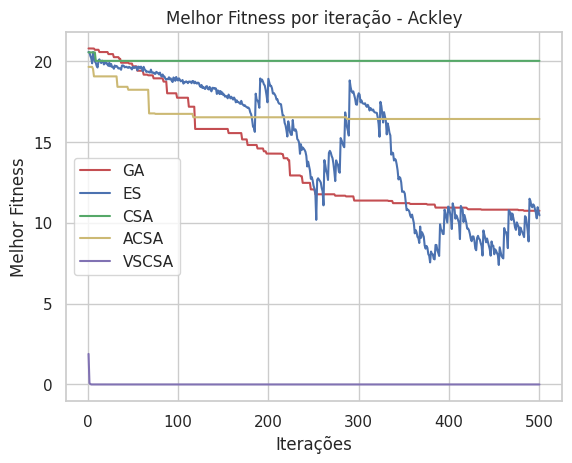

In [ ]:
plt.plot(range(1, max_generations+1), ackleyGA_bfp, linestyle='-', color='r', label='GA')
plt.plot(range(1, max_generations+1), ackleyES_bfp, linestyle='-', color='b', label='ES')
plt.plot(range(1, max_generations+1), ackleyCSA_bfp, linestyle='-', color='g', label='CSA')
plt.plot(range(1, max_generations+1), ackleyACSA_bfp, linestyle='-', color='y', label='ACSA')
plt.plot(range(1, max_generations+1), ackleyVSCSA_bfp, linestyle='-', color='m', label='VSCSA')
plt.title('Melhor Fitness por iteração - Ackley')
plt.xlabel('Iterações')
plt.ylabel('Melhor Fitness')
plt.legend()
plt.show()

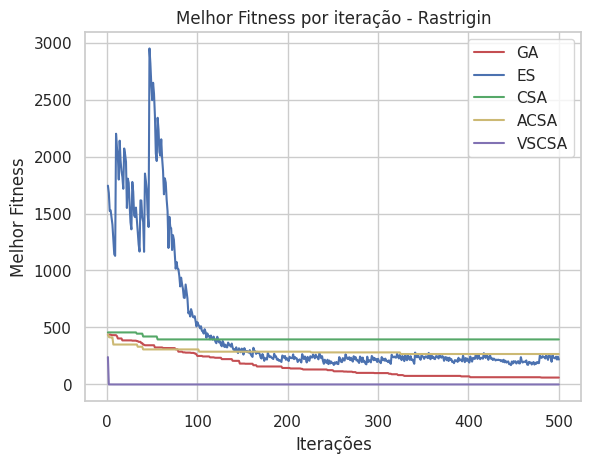

In [ ]:
plt.plot(range(1, max_generations+1), rastriginGA_bfp, linestyle='-', color='r', label='GA')
plt.plot(range(1, max_generations+1), rastriginES_bfp, linestyle='-', color='b', label='ES')
plt.plot(range(1, max_generations+1), rastriginCSA_bfp, linestyle='-', color='g', label='CSA')
plt.plot(range(1, max_generations+1), rastriginACSA_bfp, linestyle='-', color='y', label='ACSA')
plt.plot(range(1, max_generations+1), rastriginVSCSA_bfp, linestyle='-', color='m', label='VSCSA')
plt.title('Melhor Fitness por iteração - Rastrigin')
plt.xlabel('Iterações')
plt.ylabel('Melhor Fitness')
plt.legend()
plt.show()

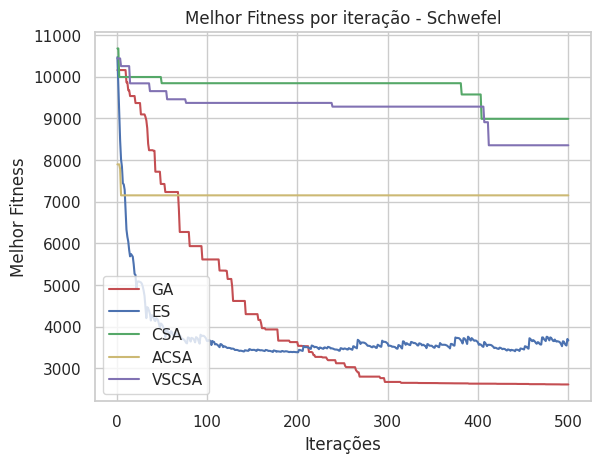

In [ ]:
plt.plot(range(1, max_generations+1), schwefelGA_bfp, linestyle='-', color='r', label='GA')
plt.plot(range(1, max_generations+1), schwefelES_bfp, linestyle='-', color='b', label='ES')
plt.plot(range(1, max_generations+1), schwefelCSA_bfp, linestyle='-', color='g', label='CSA')
plt.plot(range(1, max_generations+1), schwefelACSA_bfp, linestyle='-', color='y', label='ACSA')
plt.plot(range(1, max_generations+1), schwefelVSCSA_bfp, linestyle='-', color='m', label='VSCSA')
plt.title('Melhor Fitness por iteração - Schwefel')
plt.xlabel('Iterações')
plt.ylabel('Melhor Fitness')
plt.legend()
plt.show()

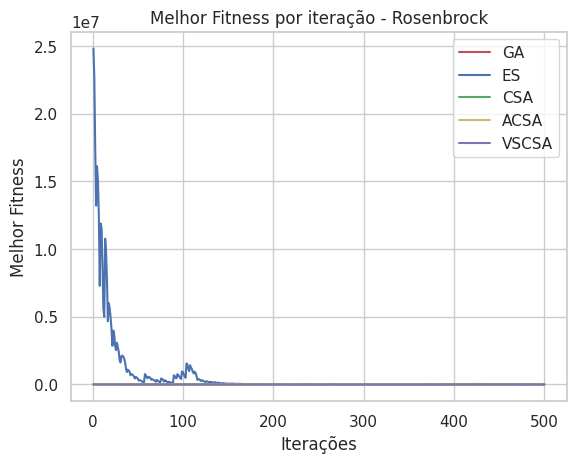

In [ ]:
plt.plot(range(1, max_generations+1), rosenbrockGA_bfp, linestyle='-', color='r', label='GA')
plt.plot(range(1, max_generations+1), rosenbrockES_bfp, linestyle='-', color='b', label='ES')
plt.plot(range(1, max_generations+1), rosenbrockCSA_bfp, linestyle='-', color='g', label='CSA')
plt.plot(range(1, max_generations+1), rosenbrockACSA_bfp, linestyle='-', color='y', label='ACSA')
plt.plot(range(1, max_generations+1), rosenbrockVSCSA_bfp, linestyle='-', color='m', label='VSCSA')
plt.title('Melhor Fitness por iteração - Rosenbrock')
plt.xlabel('Iterações')
plt.ylabel('Melhor Fitness')
plt.legend()
plt.show()

- Fitness Médio por iteração

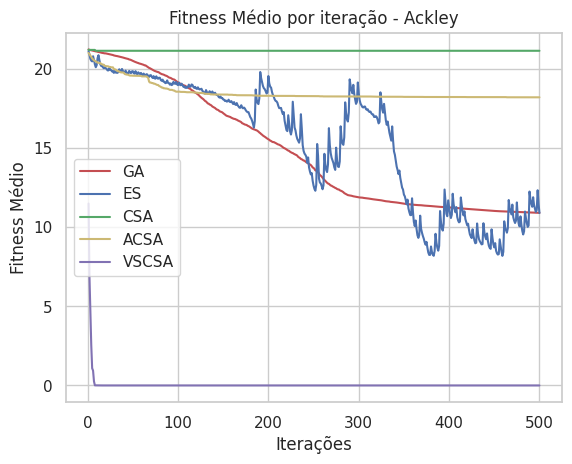

In [ ]:
plt.plot(range(1, max_generations+1), ackleyGA_afp, linestyle='-', color='r', label='GA')
plt.plot(range(1, max_generations+1), ackleyES_afp, linestyle='-', color='b', label='ES')
plt.plot(range(1, max_generations+1), ackleyCSA_afp, linestyle='-', color='g', label='CSA')
plt.plot(range(1, max_generations+1), ackleyACSA_afp, linestyle='-', color='y', label='ACSA')
plt.plot(range(1, max_generations+1), ackleyVSCSA_afp, linestyle='-', color='m', label='VSCSA')
plt.title('Fitness Médio por iteração - Ackley')
plt.xlabel('Iterações')
plt.ylabel('Fitness Médio')
plt.legend()
plt.show()

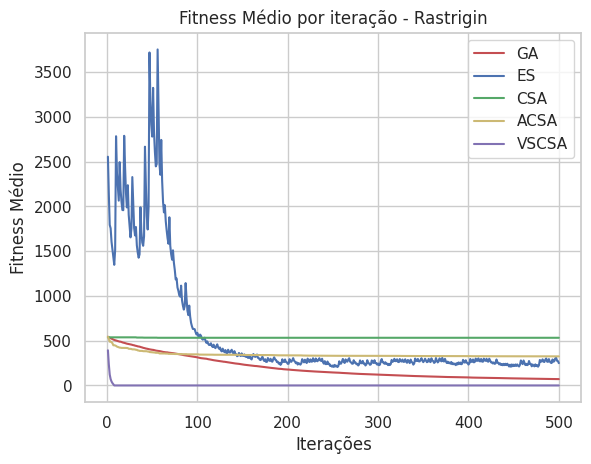

In [ ]:
plt.plot(range(1, max_generations+1), rastriginGA_afp, linestyle='-', color='r', label='GA')
plt.plot(range(1, max_generations+1), rastriginES_afp, linestyle='-', color='b', label='ES')
plt.plot(range(1, max_generations+1), rastriginCSA_afp, linestyle='-', color='g', label='CSA')
plt.plot(range(1, max_generations+1), rastriginACSA_afp, linestyle='-', color='y', label='ACSA')
plt.plot(range(1, max_generations+1), rastriginVSCSA_afp, linestyle='-', color='m', label='VSCSA')
plt.title('Fitness Médio por iteração - Rastrigin')
plt.xlabel('Iterações')
plt.ylabel('Fitness Médio')
plt.legend()
plt.show()

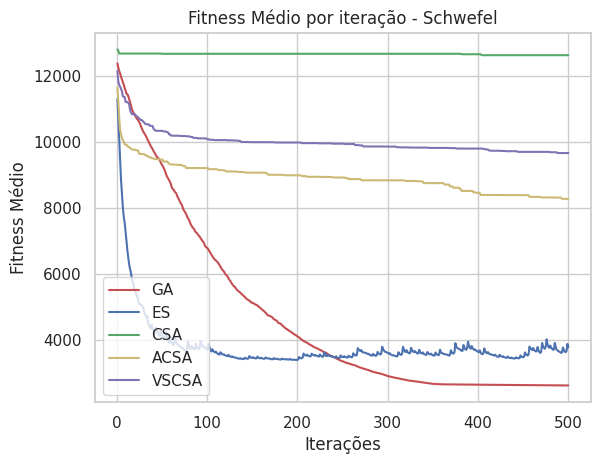

In [ ]:
plt.plot(range(1, max_generations+1), schwefelGA_afp, linestyle='-', color='r', label='GA')
plt.plot(range(1, max_generations+1), schwefelES_afp, linestyle='-', color='b', label='ES')
plt.plot(range(1, max_generations+1), schwefelCSA_afp, linestyle='-', color='g', label='CSA')
plt.plot(range(1, max_generations+1), schwefelACSA_afp, linestyle='-', color='y', label='ACSA')
plt.plot(range(1, max_generations+1), schwefelVSCSA_afp, linestyle='-', color='m', label='VSCSA')
plt.title('Fitness Médio por iteração - Schwefel')
plt.xlabel('Iterações')
plt.ylabel('Fitness Médio')
plt.legend()
plt.show()

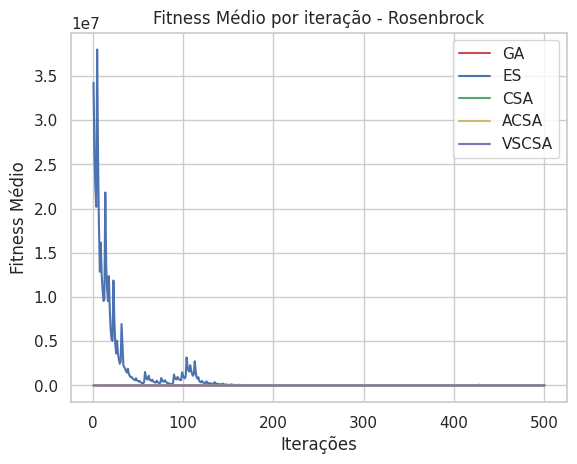

In [ ]:
plt.plot(range(1, max_generations+1), rosenbrockGA_afp, linestyle='-', color='r', label='GA')
plt.plot(range(1, max_generations+1), rosenbrockES_afp, linestyle='-', color='b', label='ES')
plt.plot(range(1, max_generations+1), rosenbrockCSA_afp, linestyle='-', color='g', label='CSA')
plt.plot(range(1, max_generations+1), rosenbrockACSA_afp, linestyle='-', color='y', label='ACSA')
plt.plot(range(1, max_generations+1), rosenbrockVSCSA_afp, linestyle='-', color='m', label='VSCSA')
plt.title('Fitness Médio por iteração - Rosenbrock')
plt.xlabel('Iterações')
plt.ylabel('Fitness Médio')
plt.legend()
plt.show()

- Desvio Padrão do Fitness por iteração

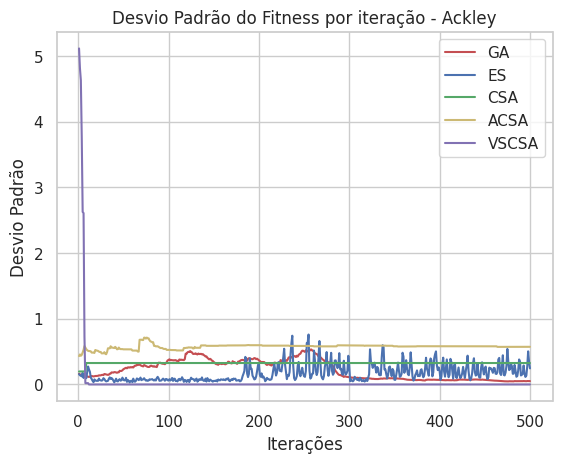

In [ ]:
plt.plot(range(1, max_generations+1), ackleyGA_fsd, linestyle='-', color='r', label='GA')
plt.plot(range(1, max_generations+1), ackleyES_fsd, linestyle='-', color='b', label='ES')
plt.plot(range(1, max_generations+1), ackleyCSA_fsd, linestyle='-', color='g', label='CSA')
plt.plot(range(1, max_generations+1), ackleyACSA_fsd, linestyle='-', color='y', label='ACSA')
plt.plot(range(1, max_generations+1), ackleyVSCSA_fsd, linestyle='-', color='m', label='VSCSA')
plt.title('Desvio Padrão do Fitness por iteração - Ackley')
plt.xlabel('Iterações')
plt.ylabel('Desvio Padrão')
plt.legend()
plt.show()

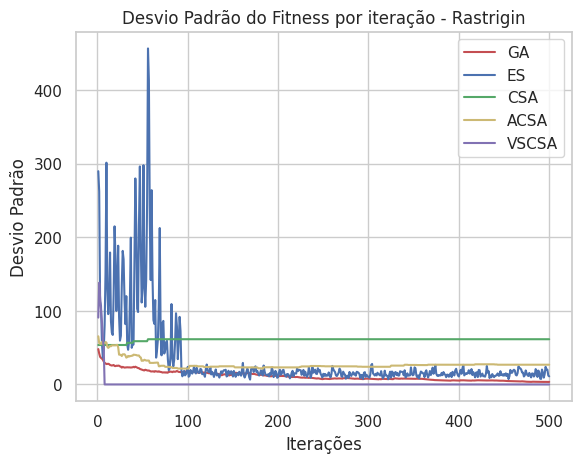

In [ ]:
plt.plot(range(1, max_generations+1), rastriginGA_fsd, linestyle='-', color='r', label='GA')
plt.plot(range(1, max_generations+1), rastriginES_fsd, linestyle='-', color='b', label='ES')
plt.plot(range(1, max_generations+1), rastriginCSA_fsd, linestyle='-', color='g', label='CSA')
plt.plot(range(1, max_generations+1), rastriginACSA_fsd, linestyle='-', color='y', label='ACSA')
plt.plot(range(1, max_generations+1), rastriginVSCSA_fsd, linestyle='-', color='m', label='VSCSA')
plt.title('Desvio Padrão do Fitness por iteração - Rastrigin')
plt.xlabel('Iterações')
plt.ylabel('Desvio Padrão')
plt.legend()
plt.show()

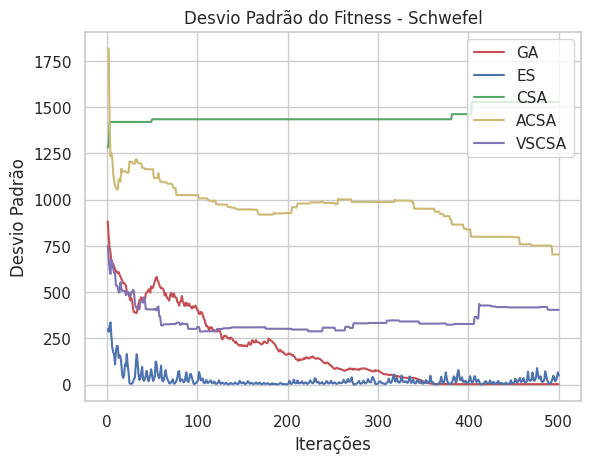

In [ ]:
plt.plot(range(1, max_generations+1), schwefelGA_fsd, linestyle='-', color='r', label='GA')
plt.plot(range(1, max_generations+1), schwefelES_fsd, linestyle='-', color='b', label='ES')
plt.plot(range(1, max_generations+1), schwefelCSA_fsd, linestyle='-', color='g', label='CSA')
plt.plot(range(1, max_generations+1), schwefelACSA_fsd, linestyle='-', color='y', label='ACSA')
plt.plot(range(1, max_generations+1), schwefelVSCSA_fsd, linestyle='-', color='m', label='VSCSA')
plt.title('Desvio Padrão do Fitness - Schwefel')
plt.xlabel('Iterações')
plt.ylabel('Desvio Padrão')
plt.legend()
plt.show()

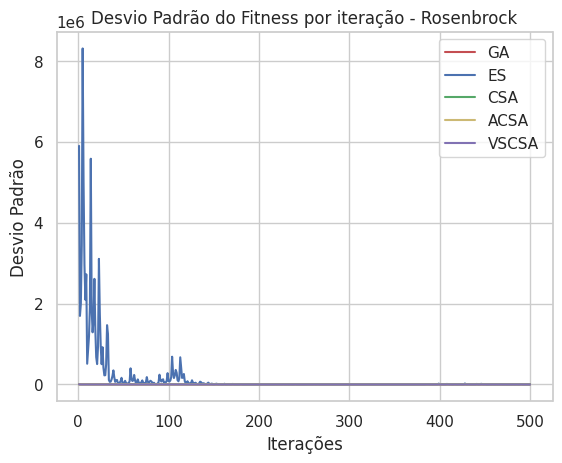

In [ ]:
plt.plot(range(1, max_generations+1), rosenbrockGA_fsd, linestyle='-', color='r', label='GA')
plt.plot(range(1, max_generations+1), rosenbrockES_fsd, linestyle='-', color='b', label='ES')
plt.plot(range(1, max_generations+1), rosenbrockCSA_fsd, linestyle='-', color='g', label='CSA')
plt.plot(range(1, max_generations+1), rosenbrockACSA_fsd, linestyle='-', color='y', label='ACSA')
plt.plot(range(1, max_generations+1), rosenbrockVSCSA_fsd, linestyle='-', color='m', label='VSCSA')
plt.title('Desvio Padrão do Fitness por iteração - Rosenbrock')
plt.xlabel('Iterações')
plt.ylabel('Desvio Padrão')
plt.legend()
plt.show()